In [6]:
import matplotlib.pyplot as plt
from sklearn import datasets, manifold
import numpy as np
import pandas as pd
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn import datasets, manifold
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
# si no funciona, umap_
from umap.umap_ import UMAP

In [4]:
def sammon(x, n, display = 1, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):



    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

In [7]:
data = pd.read_excel("4000datosSimuladosEnergia.xlsx")
sr_points = data.iloc[:, :-1]
sr_color = data.iloc[:, -1]
std = StandardScaler()
sr_points = std.fit_transform(sr_points)

Text(0.5, 1.0, 'PCA with two components')

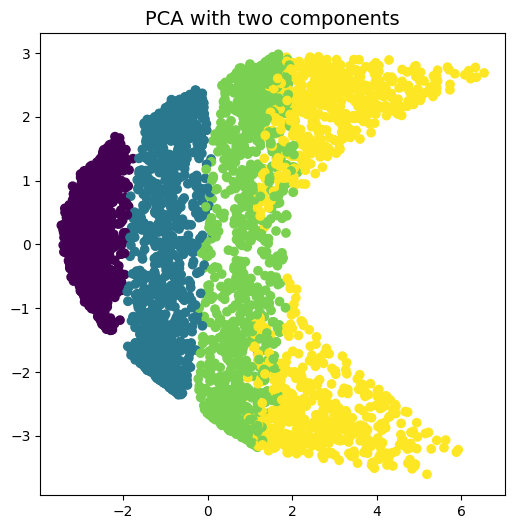

In [8]:
fig = plt.figure(figsize=(6,6))
k = 8

points = sr_points.copy()
color = sr_color.copy()

pca = PCA(n_components=2)
pca.fit(points)
X_pca = pca.transform(points)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=color)
ax.set_title('PCA with two components', size=14)

In [9]:
n_neighbors = 15  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}

n_neighbors=20, MSE=0.000000
n_neighbors=40, MSE=0.003017
n_neighbors=60, MSE=0.004662
n_neighbors=80, MSE=0.008725
n_neighbors=100, MSE=0.016309


Text(0.5, 1.0, 'LLE ltsa')

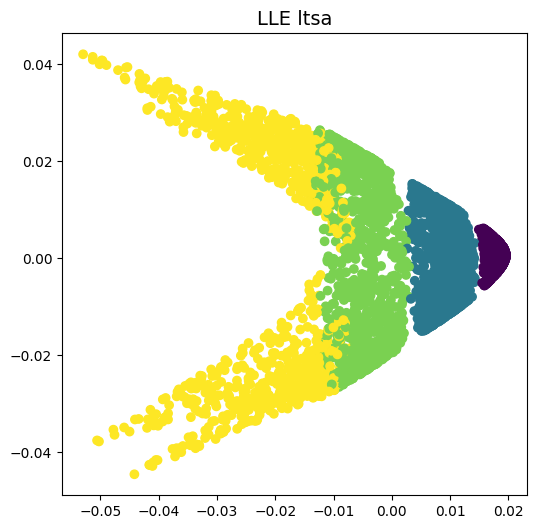

In [12]:
mse_list = []
for n in range (20,101,20):
    n_neighbors = n  # neighborhood which is used to recover the locally linear structure
    n_components = 2  # number of coordinates for the manifold
    params = {
        "n_neighbors": n_neighbors,
        "n_components": n_components,
        "eigen_solver": "auto",
        "random_state": 0,
    }
    points = sr_points.copy()
    color = sr_color.copy()
    model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
    X = model.fit_transform(points)

    mse = model.reconstruction_error_
    mse_list.append(mse)
    print(f"n_neighbors={n}, MSE={mse:.6f}")

min = 1
for i in range(len(mse_list)):
    if mse_list[i] < min:
        min = n+11

n_neighbors = min  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto",
    "random_state": 0,
}
points = sr_points.copy()
color = sr_color.copy()
model = manifold.LocallyLinearEmbedding(method="ltsa", **params)
X = model.fit_transform(points)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('LLE ltsa', size=14)


Text(0.5, 1.0, 'MDS')

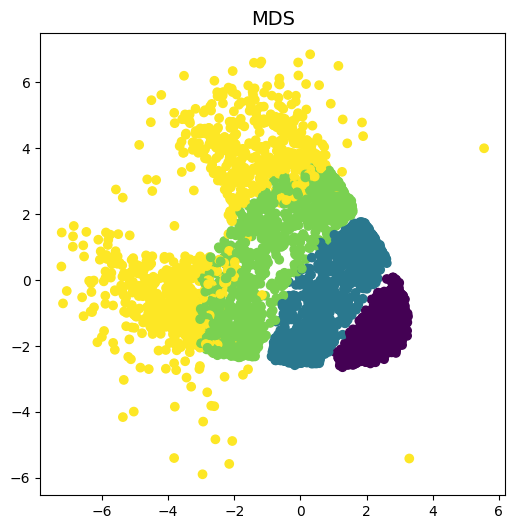

In [13]:
points = sr_points.copy()
color = sr_color.copy()
fig = plt.figure(figsize=(6,6))
model = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
X = model.fit_transform(points)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 1], c=color)
ax.set_title('MDS', size=14)

c:\Users\Alex\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


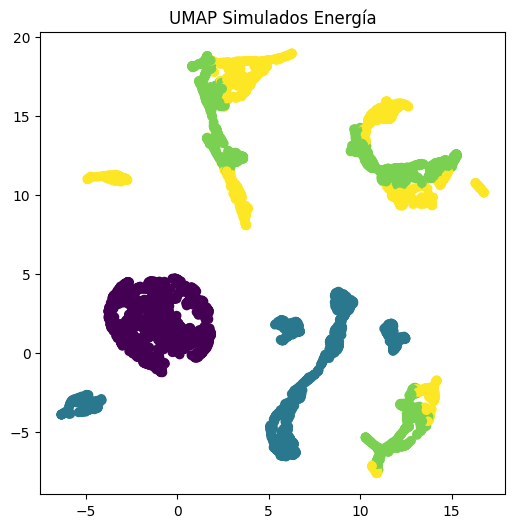

In [14]:
points = sr_points.copy()
color = sr_color.copy()

pumap = UMAP(n_components=2, init="random", random_state=0)
sr_umap = pumap.fit_transform(points)

fig, axs = plt.subplots(figsize=(6, 6))
axs.scatter(sr_umap[:, 0], sr_umap[:, 1], c=color)
_ = axs.set_title("UMAP Simulados Energía")

### Opcional

TolFun exceeded: Optimisation terminated


Text(0.5, 1.0, 'Sammon')

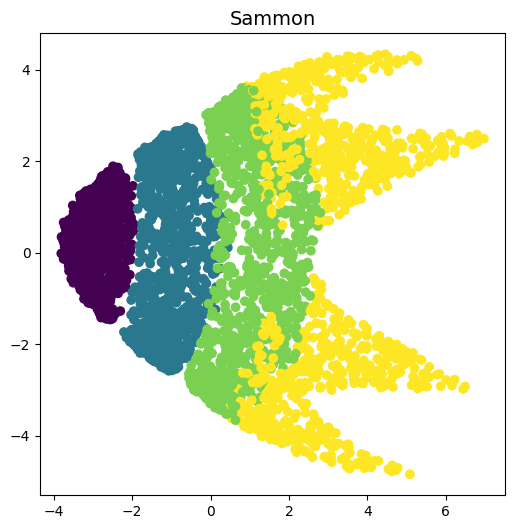

In [15]:
points = sr_points.copy()
color = sr_color.copy()
(sp,index) = np.unique(points,axis=0,return_index=True)
(y,E) = sammon(sp, 2)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y[:, 0], y[:, 1], c=color[index])
ax.set_title('Sammon', size=14)

c:\Users\Alex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\Alex\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Alex\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\Alex\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr

Text(0.5, 1.0, 'Isomap with k = 8')

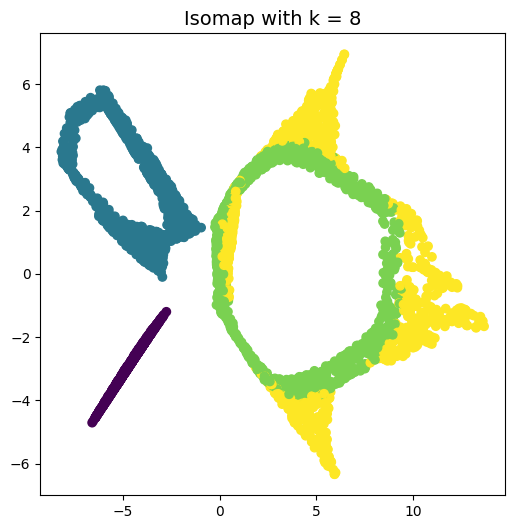

In [16]:
model = Isomap(n_components=2, n_neighbors=k)
X_iso = model.fit_transform(points)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X_iso[:, 0], X_iso[:, 1], c=color)
ax.set_title('Isomap with k = ' + str(k), size=14)

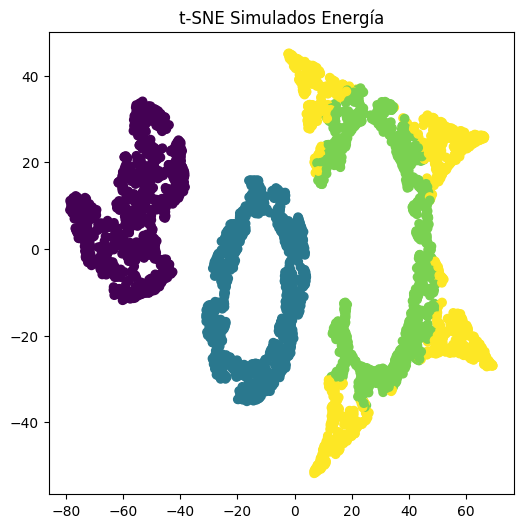

In [17]:
sr_tsne = manifold.TSNE(n_components=2, perplexity=40, random_state=0).fit_transform(
    points
)

fig, axs = plt.subplots(figsize=(6, 6))
axs.scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=color)
_ = axs.set_title("t-SNE Simulados Energía")
